# Exploratory Data Analysis

## Motivation
As new to telemetics area, I find it helpful to get to know telemetics data, play machine learning models with it, and discover some insights. 

## Data
The data set I am using is from Kaggle, [levin vehicle telematics](https://www.kaggle.com/datasets/yunlevin/levin-vehicle-telematics/discussion/155634?select=v2.csv). It's not a well documented dataset. But I did some search and found the authors of the data created a repo on Github, [LEVIN-Open Data](https://github.com/YunSolutions/levin-openData).

The authors wrote some descriptions for each column and provided some code to decode an important column, accelerometer signals. The decoding code is not really working well. After few hours struggling with it, I refined the decoding code and successfully extract the vertical, horizontal, and car movement direction from the raw accelerometer hex code. The decoding script can be found here, [decoding_acc.py](decoding_acc.py).

This notebook is to provide some insights into the data. It also includes some data preprocessing steps. 

In the end, it saves out the clean data for feature engineering.

## Data issues found
1. There are some noisy and duplicate records. 
2. Sensors are 1Hz, but a small number of signals in the data are more than 1Hz, leading to inconsisten sequences.
3. Trip history is not complete. Only 3.48% trips in the data have consecutive signals.
4. No drivier information. We don't know if it's a rental car or private car.


## Reference
[OBD-II Reference from Wikipedia](https://en.wikipedia.org/wiki/OBD-II_PIDs)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go

In [2]:
car_df = pd.read_csv("./archive/v2.csv")
car_df.shape

/var/folders/wj/kg65sk251rz1g4h8_694mm9r0000gn/T/ipykernel_52358/4169038337.py:1: DtypeWarning: Columns (0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  car_df = pd.read_csv("./archive/v2.csv")


(3120272, 17)

In [3]:
car_df.head()

,tripID,deviceID,timeStamp,accData,gps_speed,battery,cTemp,dtc,eLoad,iat,imap,kpl,maf,rpm,speed,tAdv,tPos
0,1,0.0,2017-12-22 18:43:05,10c0f8e00448fa18c80515d30000000000000000000000...,24.2612,0.0,66.0,0.0,28.6275,40.0,97.0,0.0,0.0,1010.75,23.0,0.0,0.0
1,1,0.0,2017-12-22 18:43:06,1138f8c804780a1ebdf718bcf919d10617c8e301b31017...,23.15,0.0,66.0,0.0,33.7255,40.0,98.0,0.0,0.0,815.5,21.0,0.0,0.0
2,1,0.0,2017-12-22 18:43:07,10f0f89804480612c30010c30714ce0520b7f41dbdf118...,18.7052,0.0,66.0,0.0,43.1373,40.0,98.0,0.0,0.0,862.25,17.0,0.0,0.0
3,1,0.0,2017-12-22 18:43:08,10d0f84804480d15bd0210c9f822c80017caf81ccd0517...,16.4828,0.0,66.0,0.0,41.5686,40.0,97.0,0.0,0.0,817.0,17.0,0.0,0.0
4,1,0.0,2017-12-22 18:43:09,1090f8c80480041dc9081cc50815c60511c60112c40514...,17.4088,0.0,66.0,0.0,43.1373,40.0,97.0,0.0,0.0,804.25,15.0,0.0,0.0


### Rename raw columns to improve readability

In [4]:
column_rename_dict = {
    'tripID': 'trip_id',
    'deviceID': 'device_id',
    'timeStamp': 'timestamp',
    'accData': 'accelerometer',
    'battery': 'battery_volt',
    'cTemp': 'coolant_temp',
    'dtc': 'diagnostic_trouble_code',
    'eLoad': 'engine_load',
    'iat': 'intake_air_temp',
    'maf': 'air_mass_rate',
    'rpm': 'revolutions_per_min',
    'tAdv': 'timing_advance',
    'tPos': 'throttle_position',
}

car_df = car_df.rename(columns=column_rename_dict)

### Data Dictionary

**Basic Information**

| Column | Description |
| :--- | :----------- |
| device_id | A device id is a car. One Device can have multiple trip ids. device_id + trip_id are unique trips.|
| trip_id | One id is 1 trip. A trip begins when car engine is switched on and ends when the engine is switched off. |
| timestamp | Data collection time. |
| battery_volt | The battery voltage corresponds to voltage of the battery installed in Car, which supplies electrical energy to a motor vehicle. |
| diagnostic_trouble_code | Number of diagnostic trouble codes. DTC's, or Diagnostic Trouble Codes, are used by automobile manufacturers to diagnose problems related to the vehicle. |
| accelerometer | Accelerometer and Magnetometer sensor data. The data is collected from the OBD device. Values are in terms of G-force. The data is across X, Y, Z axis where X-axis is horizontal, Y-axis is vertical, and Z-axis is the direction of movement of the car. |


**Speed related sensors**

| Column | Description |
| :--- | :----------- |
| gps_speed | The speed in kmph (kilometers per hour) as noted from GPS sensor. |
| speed | Speed data as collected from OBD device mounted in the car. |
| kpl | KMPL is mileage in kilometres per litre. It is a derived metric derived from speed and fuel to air mass flow ratio. This ratio is constant in case of Petrol cars while changes for other Fuel types. Hence, the KMPL value is accurate for petrol cars, and contain some error in case of other fuel types. |
| revolutions_per_min | engine RPM. The number of turns in one minute. |


**Temperature related sensors**

| Column | Description |
| :--- | :----------- |
| coolant_temp | The Temperature of the engine coolant of an internal combustion engine. The normal operating temperature for most engines is in a range of 90 to 104 degree Celsius (195 to 220 degrees Fahrenheit). |
| intake_air_temp | The Intake Air Temperature sensor (IAT) has been utilised as an Engine Control Unit (ECU) input signal, as a requirement for calculating the Air Mass volume for the incoming air charge. This is, to assist in determining the correct engine fuel requirement to suit the operating air temperature. |
| timing_advance | Timing advance refers to the number of degrees before top dead center (BTDC) that the spark will ignite the air-fuel mixture in the combustion chamber during the compression stroke. |


**Air mass flow related sensors**

| Column | Description |
| :--- | :----------- |
| imap | The manifold absolute pressure sensor (MAP sensor) is one of the sensors used in an internal combustion engine's electronic control system. The MAP sensor sensor provides instantaneous manifold pressure information to the engine's electronic control unit (ECU). The data is used to calculate air density and determine the engine's air mass flow rate, which in turn determines the required fuel metering for optimum combustion (see stoichiometry) and influence the advance or retard of ignition timing. |
| engine_load | Engine load measures how much air (and fuel) you're sucking into the engine and then compares that value to the theoretical maximum. |
| throttle_position | A throttle position sensor (TPS) is a sensor used to monitor the air intake of an engine. |
| air_mass_rate | A mass (air) flow sensor (MAF) is used to find out the mass flow rate of air entering a fuel-injected internal combustion engine. The air mass information is necessary for the engine control unit (ECU) to balance and deliver the correct fuel mass to the engine. |

### Noisy points

In [5]:
noise_index = car_df["device_id"] == "deviceID"
car_df[noise_index].head()

,trip_id,device_id,timestamp,accelerometer,gps_speed,battery_volt,coolant_temp,diagnostic_trouble_code,engine_load,intake_air_temp,imap,kpl,air_mass_rate,revolutions_per_min,speed,timing_advance,throttle_position
106461,tripID,deviceID,timeStamp,accData,gps_speed,battery,cTemp,dtc,eLoad,iat,imap,kpl,maf,rpm,speed,tAdv,tPos
376682,tripID,deviceID,timeStamp,accData,gps_speed,battery,cTemp,dtc,eLoad,iat,imap,kpl,maf,rpm,speed,tAdv,tPos
630522,tripID,deviceID,timeStamp,accData,gps_speed,battery,cTemp,dtc,eLoad,iat,imap,kpl,maf,rpm,speed,tAdv,tPos
631504,tripID,deviceID,timeStamp,accData,gps_speed,battery,cTemp,dtc,eLoad,iat,imap,kpl,maf,rpm,speed,tAdv,tPos
676250,tripID,deviceID,timeStamp,accData,gps_speed,battery,cTemp,dtc,eLoad,iat,imap,kpl,maf,rpm,speed,tAdv,tPos


In [6]:
# Remove noise
car_df = car_df[~noise_index]
print("Data Size after removing noise: {}".format(car_df.shape))

Data Size after removing noise: (3120240, 17)


### Data type casting

In [7]:
first_datatype_casting = {
    'device_id': np.float32,
    'trip_id': np.float32,
    'timestamp': "datetime64[ns]",
    'battery_volt': np.float32,
    'diagnostic_trouble_code': np.float32,
    'accelerometer': str,
    'gps_speed': np.float32,
    'speed': np.float32,
    'kpl': np.float32,
    'revolutions_per_min': np.float32,
    'coolant_temp': np.float32,
    'intake_air_temp': np.float32,
    'timing_advance': np.float32,
    'imap': np.float32,
    'engine_load': np.float32,
    'throttle_position': np.float32,
    'air_mass_rate': np.float32,
}

# Cast integers for memory efficiency
second_datatype_casting = {
    'device_id': int,
    'trip_id': int,
    'diagnostic_trouble_code': int,
    'speed': int,
    'coolant_temp': int,
    'intake_air_temp': int,
    'imap': int,
}

car_df = car_df.astype(first_datatype_casting).astype(second_datatype_casting)
car_df.dtypes

trip_id                             int64
device_id                           int64
timestamp                  datetime64[ns]
accelerometer                      object
gps_speed                         float32
battery_volt                      float32
coolant_temp                        int64
diagnostic_trouble_code             int64
engine_load                       float32
intake_air_temp                     int64
imap                                int64
kpl                               float32
air_mass_rate                     float32
revolutions_per_min               float32
speed                               int64
timing_advance                    float32
throttle_position                 float32
dtype: object

### Timestamp Range and sort signal history by timestamp

In [8]:
car_df['timestamp'].min(), car_df['timestamp'].max()

(Timestamp('2017-11-18 16:23:30'), Timestamp('2018-01-31 23:18:50'))

In [9]:
car_df = car_df.sort_values(['device_id', 'trip_id', 'timestamp'], ascending=True)

### Duplicates

In [10]:
print("Duplicate Rate: {:,.3f}%".format(
    np.sum(car_df.duplicated()) / car_df.shape[0] * 100))

# Drop all duplicates
car_df = car_df.drop_duplicates()
print("Data Size after removing duplicates: {}".format(car_df.shape))

Duplicate Rate: 26.543%
Data Size after removing duplicates: (2292031, 17)


### Missing Values

In [11]:
car_df.isnull().values.any()

False

### Check signal frequency for each sensor
In over 99% of the time, each sensor had only 1 unique signal. It can be considered as 1 Hz.

This means 1 timestamp can be considered as 1 time step.
It requires signal preprocessing to only keep the last signal for each timestamp.

In [12]:
def check_signal_frequency(df):
    # Calculate the signal frequency of each sensor (number of unique values per timestamp)
    for c in ['accelerometer', 'gps_speed',
           'battery_volt', 'coolant_temp', 'diagnostic_trouble_code',
           'engine_load', 'intake_air_temp', 'imap', 'kpl', 'air_mass_rate',
           'revolutions_per_min', 'speed', 'timing_advance', 'throttle_position',]:

        signal_frequency = car_df[['device_id', 'trip_id', 'timestamp', c]]\
            .drop_duplicates()\
            .groupby(['device_id', 'trip_id', 'timestamp'])\
            .count()

        print("{} in {:,.3f}% time had 1 signal per second (1 Hz)".format(
            c, 
            signal_frequency[signal_frequency[c] == 1].shape[0] / signal_frequency.shape[0] * 100))

In [13]:
check_signal_frequency(car_df)

accelerometer in 99.226% time had 1 signal per second (1 Hz)
gps_speed in 100.000% time had 1 signal per second (1 Hz)
battery_volt in 99.934% time had 1 signal per second (1 Hz)
coolant_temp in 99.960% time had 1 signal per second (1 Hz)
diagnostic_trouble_code in 100.000% time had 1 signal per second (1 Hz)
engine_load in 99.651% time had 1 signal per second (1 Hz)
intake_air_temp in 99.972% time had 1 signal per second (1 Hz)
imap in 99.757% time had 1 signal per second (1 Hz)
kpl in 99.697% time had 1 signal per second (1 Hz)
air_mass_rate in 99.691% time had 1 signal per second (1 Hz)
revolutions_per_min in 99.625% time had 1 signal per second (1 Hz)
speed in 99.745% time had 1 signal per second (1 Hz)
timing_advance in 99.934% time had 1 signal per second (1 Hz)
throttle_position in 99.879% time had 1 signal per second (1 Hz)


### Keep the last signal for each timestamp
Some timestamps had multiple different signals. Since all sensors are considered as 1 Hz, **it's good to only keep the last signal and remove the rest.**

In [14]:
redundant_signals = car_df.duplicated(subset=['device_id', 'trip_id', 'timestamp'], 
                                      keep='last')

print("{:,.3f}% redundant signals".format(sum(redundant_signals) / car_df.shape[0]))

car_df = car_df[~redundant_signals]

0.009% redundant signals


In [15]:
check_signal_frequency(car_df)

accelerometer in 100.000% time had 1 signal per second (1 Hz)
gps_speed in 100.000% time had 1 signal per second (1 Hz)
battery_volt in 100.000% time had 1 signal per second (1 Hz)
coolant_temp in 100.000% time had 1 signal per second (1 Hz)
diagnostic_trouble_code in 100.000% time had 1 signal per second (1 Hz)
engine_load in 100.000% time had 1 signal per second (1 Hz)
intake_air_temp in 100.000% time had 1 signal per second (1 Hz)
imap in 100.000% time had 1 signal per second (1 Hz)
kpl in 100.000% time had 1 signal per second (1 Hz)
air_mass_rate in 100.000% time had 1 signal per second (1 Hz)
revolutions_per_min in 100.000% time had 1 signal per second (1 Hz)
speed in 100.000% time had 1 signal per second (1 Hz)
timing_advance in 100.000% time had 1 signal per second (1 Hz)
throttle_position in 100.000% time had 1 signal per second (1 Hz)


### Remove invalid accelerometer code
Accelerometer code should have 162 characters.  

In [16]:
car_df['accelerometer'].str.len().value_counts()

162    1953951
1       318498
Name: accelerometer, dtype: int64

In [17]:
car_df = car_df[car_df['accelerometer'].str.len() == 162]
car_df.shape

(1953951, 17)

### Signal Completeness
Only 3.48% trips have a complete signal history. Filling missing records is computationally expensive.

**A simply workaround is to treat timestamps as conseuctive signals.**

In [18]:
def unique_timestamps(x): 
    return len(set(x))

trip_df = car_df[['device_id', 'trip_id', 'timestamp']]\
    .groupby(['device_id', 'trip_id'])\
    .agg({'timestamp': [unique_timestamps, min, max]})\
    .sort_values(('timestamp', 'unique_timestamps'))\
    .reset_index()

In [19]:
trip_df['time_steps'] = (trip_df[('timestamp', 'max')] - trip_df[('timestamp', 'min')]).dt.seconds
trip_df.head(5)

device_id trip_id         timestamp                                          \
                    unique_timestamps                 min                 max   
0         8       1               150 2018-01-12 11:59:52 2018-01-12 12:02:26   
1        14       1               160 2017-12-21 10:59:18 2017-12-21 11:02:01   
2         5      41               161 2018-01-03 18:55:43 2018-01-03 19:11:01   
3        10      62               161 2017-12-07 20:49:54 2017-12-07 20:52:46   
4        14       3               162 2017-12-24 09:37:22 2017-12-24 09:40:04   

  time_steps  
              
0        154  
1        163  
2        918  
3        172  
4        162

In [20]:
trip_df['is_complete'] = (trip_df['time_steps'] == trip_df[('timestamp', 'unique_timestamps')]) & \
                        (trip_df['time_steps'] > 1)

print("{:,.3}% of trips have a complete signal history.".format(
    trip_df[(trip_df['is_complete'] == True)].shape[0] / trip_df.shape[0] * 100))

3.7% of trips have a complete signal history.


### Append a label to indicate whether or not a trip has a complete history

In [21]:
trip_labels = trip_df[['device_id', 'trip_id', 'is_complete']]
trip_labels.columns = trip_labels.columns.droplevel(1)
car_df = car_df.merge(trip_labels, on=['device_id', 'trip_id'], how='left')

### Summary statistics

In [22]:
obd_sensors_cols = [
    'battery_volt', 'diagnostic_trouble_code', 
    'gps_speed', 'speed', 'kpl', 'revolutions_per_min', 
    'coolant_temp', 'intake_air_temp', 'timing_advance',
    'engine_load',  'imap', 'air_mass_rate', 'throttle_position',
]

In [23]:
car_df[obd_sensors_cols].describe()

,battery_volt,diagnostic_trouble_code,gps_speed,speed,kpl,revolutions_per_min,coolant_temp,intake_air_temp,timing_advance,engine_load,imap,air_mass_rate,throttle_position
count,1.953951e+06,1.953951e+06,1.953951e+06,1.953951e+06,1.953951e+06,1.953951e+06,1.953951e+06,1.953951e+06,1.953951e+06,1.953951e+06,1.953951e+06,1.953951e+06,1.953951e+06
mean,2.955781e+00,3.699683e-03,2.353997e+01,2.233657e+01,5.284618e+00,9.831083e+02,6.159739e+01,2.677118e+01,2.335320e+00,3.046894e+01,6.958680e+01,7.915453e+00,1.750107e+01
std,5.645492e+00,6.877455e-01,2.602331e+01,2.543767e+01,9.480646e+00,7.014600e+02,3.400195e+01,1.567976e+01,8.010269e+00,2.742728e+01,5.016890e+01,9.307199e+00,2.959769e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-4.000000e+01,-4.000000e+01,-2.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.400000e+01,2.000000e+01,0.000000e+00,0.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,1.648280e+01,1.500000e+01,1.819900e+00,9.980000e+02,8.000000e+01,3.000000e+01,0.000000e+00,2.666670e+01,9.600000e+01,7.050000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,3.666960e+01,3.600000e+01,7.170600e+00,1.461000e+03,8.800000e+01,3.700000e+01,0.000000e+00,4.862750e+01,1.020000e+02,1.222000e+01,1.921570e+01
max,1.544000e+01,1.290000e+02,3.355454e+02,1.490000e+02,1.611200e+03,5.764000e+03,1.000000e+02,6.900000e+01,5.050000e+01,9.960780e+01,2.540000e+02,1.780800e+02,9.960780e+01


### Validate signals using OBD-II reference

[OBD-II Reference from Wikipedia](https://en.wikipedia.org/wiki/OBD-II_PIDs)

All signals are in the expected ranges.

In [24]:
valid_signal_ranges = {
    'speed': (0, 255),
    'revolutions_per_min': (0, 16383.75),
    'coolant_temp': (-40, 215),
    'intake_air_temp': (-40, 215),
    'timing_advance': (-64, 63.5),
    'engine_load': (0, 100),
    'imap': (0, 255),
    'air_mass_rate': (0, 655.35),
    'throttle_position': (0, 100),
}

In [25]:
def validate_signals(df, valid_signal_ranges):
    for col, (minimum, maximum) in valid_signal_ranges.items():
        invalid_index = (car_df[col] > maximum) | (car_df[col] < minimum)
        if sum(invalid_index) > 0:
            print("{} has {} invalid signals.".format(col, sum(invalid_index)))
        else:
            print("No invalid signal for {}.".format(col))

In [26]:
validate_signals(car_df, valid_signal_ranges)

No invalid signal for speed.
No invalid signal for revolutions_per_min.
No invalid signal for coolant_temp.
No invalid signal for intake_air_temp.
No invalid signal for timing_advance.
No invalid signal for engine_load.
No invalid signal for imap.
No invalid signal for air_mass_rate.
No invalid signal for throttle_position.


### Plot signal distributions

In [27]:
def plot_feature_dist(df):
    cols = df.columns
    fig, axes = plt.subplots(7, 2, figsize=(24, 30))
    axes = axes.flatten()
    sns.set_palette(sns.color_palette(["#2a9d8f", "#e9c46a"]))

    for i, ax in enumerate(axes):
        if i < df.columns.shape[0]:
            sns.kdeplot(data=df, x=cols[i], ax=ax, palette = ["#2a9d8f"])
#             ax.set_xticks([])
            ax.set_yticks([])
            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.spines['left'].set_visible(False)
            ax.set_title(cols[i], loc='center', weight='bold', fontsize=12)

#     fig.supxlabel('Distribution', ha='center', fontweight='bold')

#     fig.tight_layout()
    plt.show()

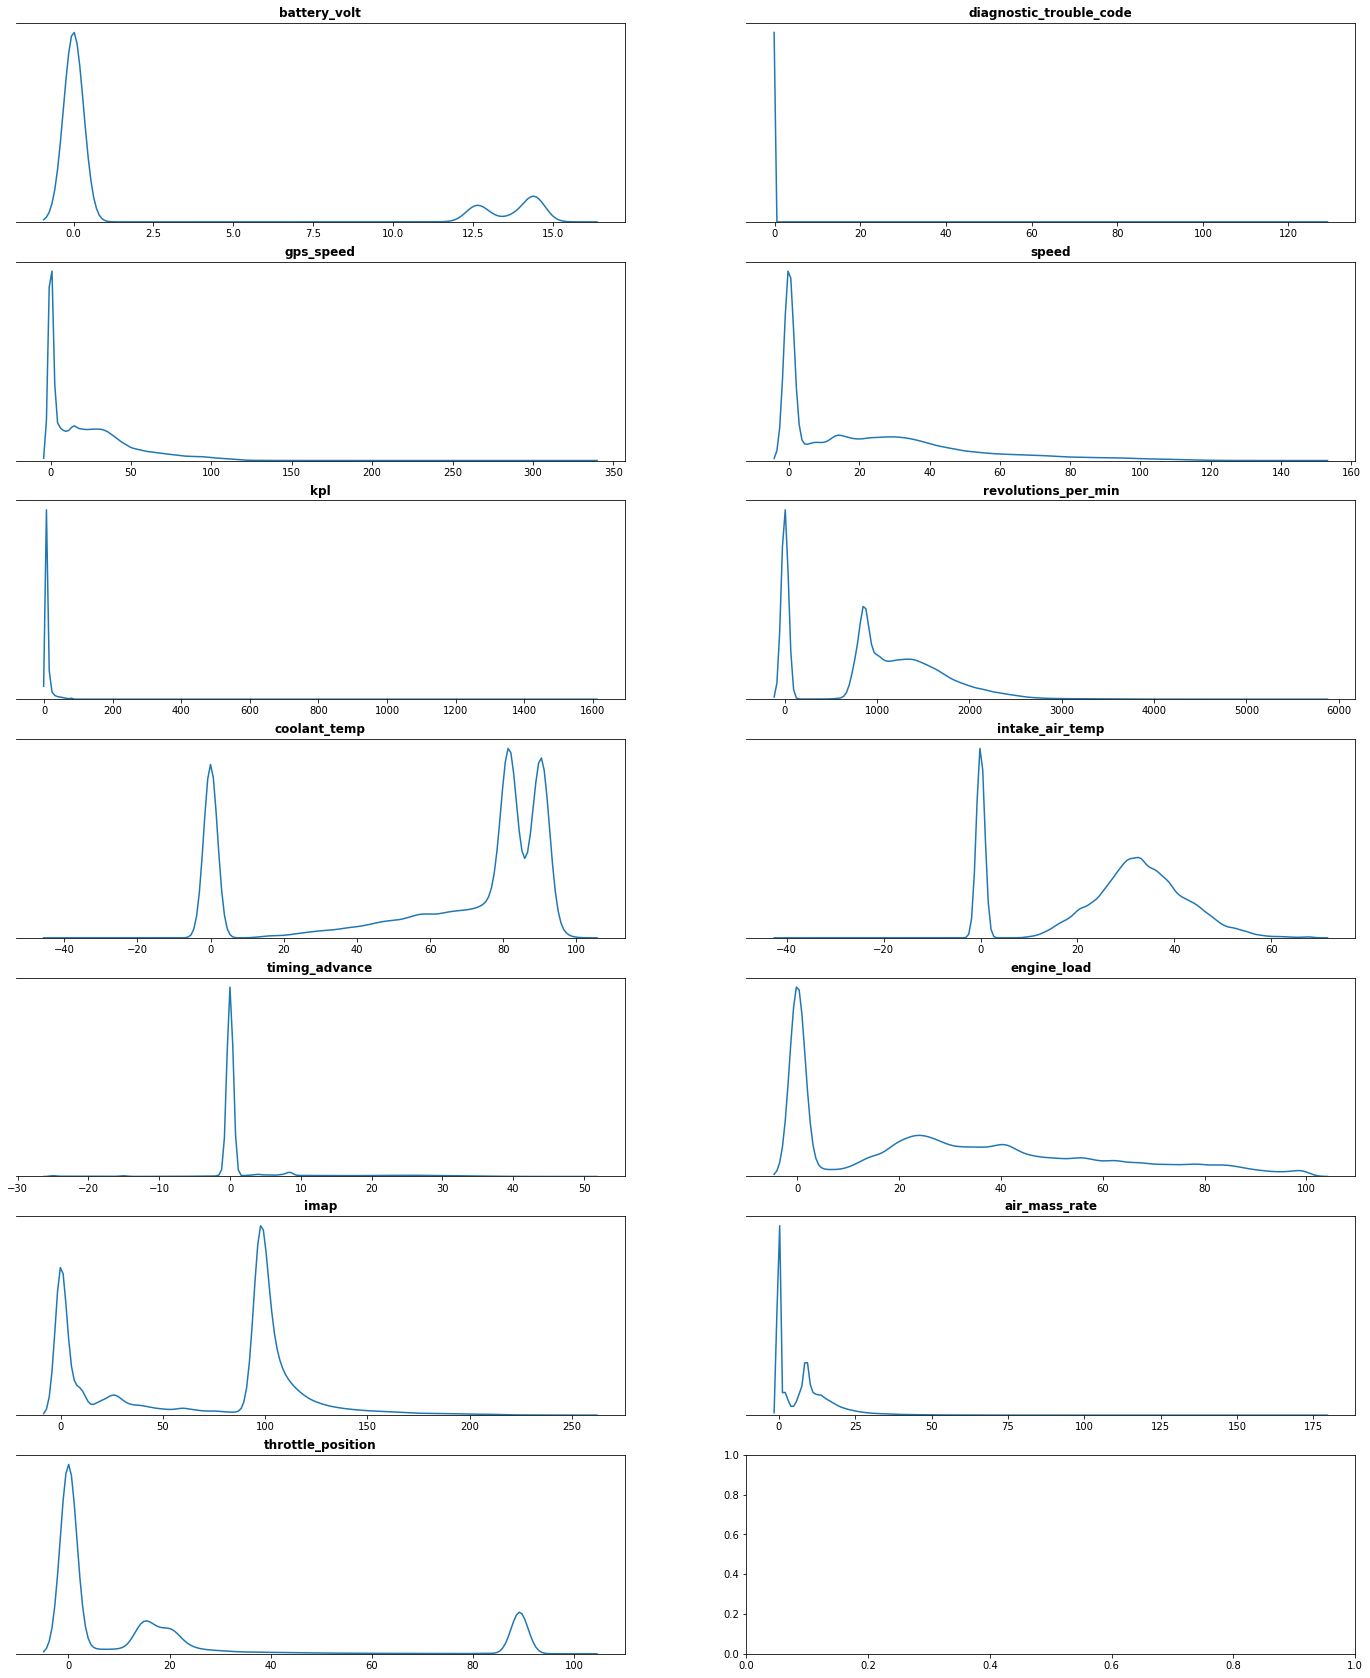

In [28]:
plot_feature_dist(car_df[obd_sensors_cols])

### GPS speed vs. Speed

`GPS speed` has a similar distribution as `speed`. 

`GPS speed` is an average speed with a slight delay. It's more accurate overall but may be less accurate when the road has many twists or turns.

75% of their differences are less than 2, which means they are very close. And `GPS speed` is a bit delay.

In [29]:
difference = car_df['gps_speed'] - car_df['speed']
difference.describe()

count    1.953951e+06
mean     1.203396e+00
std      7.296270e+00
min     -1.149959e+02
25%     -2.556000e-01
50%      0.000000e+00
75%      2.002001e+00
max      2.835454e+02
dtype: float64

### Hard brake analysis

When the speed signal dramatically dropped in a short time, it can be a hard brake.

We can see a hard brake happened between time step 90 and 100.

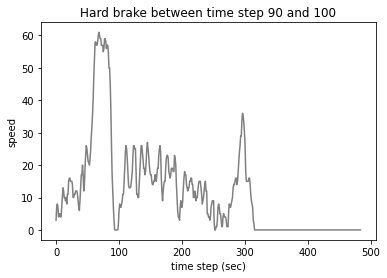

In [30]:
def plot_signal_chart(df):
    
    # Drop the first record to smooth the signals
    df = df.loc[1:].reset_index(drop=True).reset_index()\
        .rename(columns={'index': 'time step (sec)'})
    
    sns.lineplot(x=df['time step (sec)'], y=df['speed'], color='grey')\
        .set_title('Hard brake between time step 90 and 100')
    

plot_signal_chart(car_df[(car_df['device_id'] == 10) & (car_df['trip_id'] == 157)])

### Correlated or redundant signals
- `gps_speed` is **96%** correlated with `speed`.
- `coolant_temp` and `intake_air_temp` are **86.3%** correlated.
- `revolutions_per_min` is **80%** correlated with `speed`.

In [31]:
def style_high_correlation(v, corr_threshold, props=''):    
    return props if np.abs(v) >= corr_threshold and v != 1 else None

car_df[obd_sensors_cols].corr().style.applymap(style_high_correlation, 
                                               corr_threshold=0.85, 
                                               props='color:red;')

,battery_volt,diagnostic_trouble_code,gps_speed,speed,kpl,revolutions_per_min,coolant_temp,intake_air_temp,timing_advance,engine_load,imap,air_mass_rate,throttle_position
battery_volt,1.000000,0.009534,0.019295,0.039548,0.331887,0.195686,0.256623,0.230962,0.553437,0.184767,-0.411414,-0.187176,0.049571
diagnostic_trouble_code,0.009534,1.000000,-0.004850,-0.004724,-0.002999,-0.006107,-0.001938,0.000084,-0.003707,0.007027,-0.006417,-0.004562,-0.000332
gps_speed,0.019295,-0.004850,1.000000,0.960049,0.422999,0.753124,0.469250,0.258842,0.098400,0.295830,0.511729,0.550582,0.166321
speed,0.039548,-0.004724,0.960049,1.000000,0.435463,0.800148,0.495498,0.274033,0.129318,0.338025,0.532427,0.583933,0.193582
kpl,0.331887,-0.002999,0.422999,0.435463,1.000000,0.413795,0.297136,0.196081,0.023007,0.071356,0.051553,0.149526,0.076173
revolutions_per_min,0.195686,-0.006107,0.753124,0.800148,0.413795,1.000000,0.690476,0.519391,0.260010,0.425934,0.612420,0.600164,0.309666
coolant_temp,0.256623,-0.001938,0.469250,0.495498,0.297136,0.690476,1.000000,0.863834,0.144089,0.507776,0.637228,0.431915,0.266001
intake_air_temp,0.230962,0.000084,0.258842,0.274033,0.196081,0.519391,0.863834,1.000000,0.112739,0.482714,0.565335,0.266782,0.153835
timing_advance,0.553437,-0.003707,0.098400,0.129318,0.023007,0.260010,0.144089,0.112739,1.000000,0.157627,-0.223067,-0.098302,0.019037
engine_load,0.184767,0.007027,0.295830,0.338025,0.071356,0.425934,0.507776,0.482714,0.157627,1.000000,0.443878,0.322457,0.061208


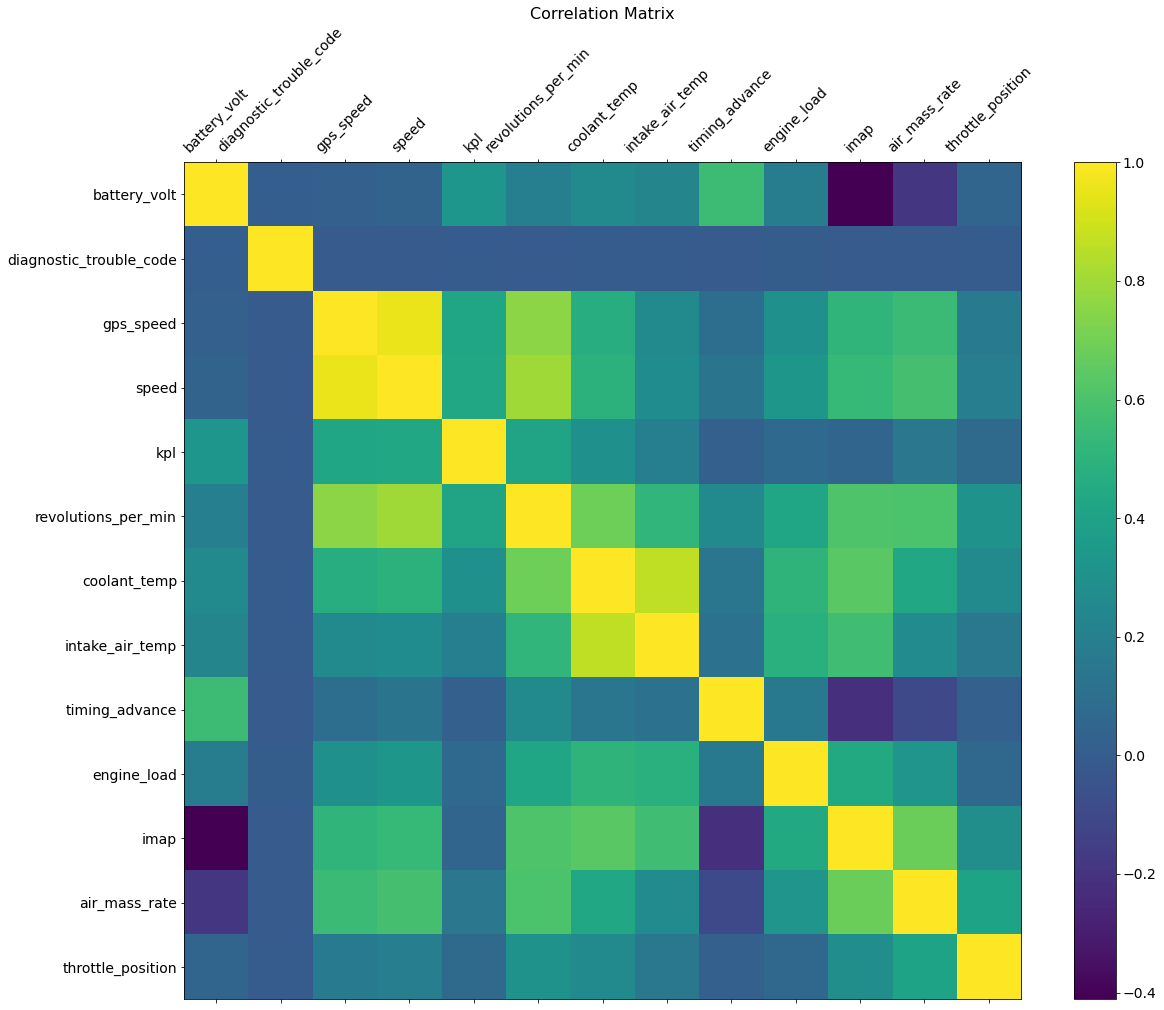

In [32]:
f = plt.figure(figsize=(19, 15))
plt.matshow(car_df[obd_sensors_cols].corr(), fignum=f.number)

plt.xticks(range(car_df[obd_sensors_cols].columns.shape[0]), 
           car_df[obd_sensors_cols].corr().columns, 
           fontsize=14, 
           rotation=45)

plt.yticks(range(car_df[obd_sensors_cols].columns.shape[0]), 
           car_df[obd_sensors_cols].corr().columns, 
           fontsize=14)

cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

### Hourly car usage distribution

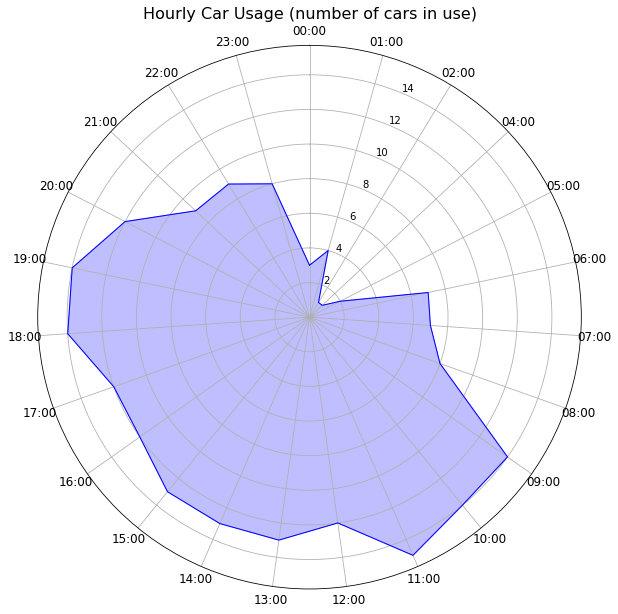

In [33]:
def plot_car_usage_radar_chart(df):
    df['hour'] = df['timestamp'].dt.hour.astype(str).str.zfill(2)
    df['hour'] = df['hour'] + ":00"
    
    hourly_usage = df[['hour','device_id']]\
                    .drop_duplicates()\
                    .groupby('hour')\
                    .count()\
                    .reset_index()\
                    .rename(columns={'device_id': 'usage'})
    
    labels = list(hourly_usage['hour'].values)
    values = list(hourly_usage['usage'].values)

    num_vars = len(labels)

    # Split the circle into even parts and save the angles
    # so we know where to put each axis.
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # The plot is a circle, so we need to "complete the loop"
    # and append the start value to the end.
    values += values[:1]
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    plt.title('Hourly Car Usage (number of cars in use)', size=16)
    plt.xticks(angles[:-1], labels, size=12, ha='center')
#     ax.set_yticklabels([])
    
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    
    # Draw the outline of our data.
    ax.plot(angles, values, color='blue', linewidth=1)
    
    # Fill it in.
    ax.fill(angles, values, color='blue', alpha=0.25)
    
    
plot_car_usage_radar_chart(car_df.copy())

### Save out clean data

In [34]:
# Recorder columns
car_df = car_df[['device_id', 'trip_id', 'timestamp'] + obd_sensors_cols + ['accelerometer'] + ['is_complete']]

car_df.to_csv('clean_signals.csv', index=False)